In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle
import os
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

In [8]:
df = pd.read_csv('../data/oasis_longitudinal.csv')

# drop Hand (since all R) and MRI ID
df_cleaned = df.drop(columns=['Hand','MRI ID'])
print(df_cleaned.columns)

# drop eTIV due to high collinarity wth ASF and CDR due to extremely high correlation with target
df_cleaned = df_cleaned.drop(columns = ['eTIV', 'CDR'])

# drop target variable and subject ID
X = df_cleaned.drop(columns = ['Group', 'Subject ID'])
y = df_cleaned['Group']
subject_ids = df_cleaned['Subject ID'] # groups (for group structure, not labels)

Index(['Subject ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES',
       'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')


In [9]:
# Construct preprocesser (code from eda notebook -- tested it there)
# Decide which encoder to use on each feature
minmax_ftrs = ['Age', 'MMSE', 'EDUC']
onehot_ftrs = ['M/F']
ordinal_ftrs = ['Visit', 'SES']
ordinal_cats = [[1, 2, 3, 4, 5], [-1, 1.0, 2.0, 3.0, 4.0, 5.0]]
std_ftrs = ['MR Delay', 'nWBV', 'ASF']

# Ordinal encoder (separate because need imputer for SES missing values)
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value=-1)),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# Collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('onehot', OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('std', StandardScaler(), std_ftrs)])

## Pipeline w/ Multivariate Imputation ##
After preprocessing, the only remaining variable with missing values is MMSE, and it only has 2 missing values. Since MMSE is the cognitive test score, I thought that it was reasonable to do multivariate imputation, especially considering how few missing values are in the dataset.

In [10]:
def MLpipe_imp_SGKFold(X, y, preprocessor, ML_algo, param_grid, model_name, eval_metric):
    '''
    Pipeline with:
        Missing values handling method - Multivariate Imputation
        Splitting method -- StratifiedGroupKFold
        Evaluation metric -- Depends on input
    '''

    test_scores = []
    best_models = []

    num_states = 10

    for i in range(num_states):
        # Define random state
        random_state = 29*i
        print(f"---Running random state {random_state}---")

        # ---SPLIT---
        outer_split = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state) # Outer split: split test and other

        for other_idx, test_idx in outer_split.split(X, y, groups=subject_ids):
            break # Break after the first split to separate out the test set for this state
        
        # print(f"\n[Outer Split] Fold {i + 1}")
        # print(f"Train+Validation size: {len(other_idx)}, Test size: {len(test_idx)}")
        # print(f"Train+Validation percentage: {len(other_idx) / len(X) * 100:.2f}%, Test percentage: {len(test_idx) / len(X) * 100:.2f}%")
        # print(f"Groups in Train+Validation: {pd.Series(subject_ids.iloc[other_idx]).nunique()}, Groups in Test: {pd.Series(subject_ids.iloc[test_idx]).nunique()}")

        X_other = X.iloc[other_idx]
        y_other = y.iloc[other_idx]
        subject_ids_other = subject_ids.iloc[other_idx] 
        X_test = X.iloc[test_idx]
        y_test = y.iloc[test_idx]

        kf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=random_state) # Inner split: 4 fold CV

        # ---PREPROCESS---
        # Main preprocessor is fed into function in "preprocessor"
        final_scaler = StandardScaler()

        # ---IMPUTE---
        imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=1), random_state=random_state, max_iter=1000000)

        # ---CONSTRUCT PIPELINE & GRID SEARCH---
        pipeline = make_pipeline(preprocessor, imputer, final_scaler, ML_algo)

        if eval_metric == "accuracy":
            grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='accuracy', return_train_score=True, n_jobs=-1, verbose=True)
        elif eval_metric == "precision":
            grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='precision_macro', return_train_score=True, n_jobs=-1, verbose=True)
        elif eval_metric == "f1_macro":
            grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='f1_macro', return_train_score=True, n_jobs=-1, verbose=True)
        elif eval_metric == "f1_weighted":
            grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='f1_weighted', return_train_score=True, n_jobs=-1, verbose=True)
        else:
            raise ValueError("Evaluation metric not handled in this pipeline.")
        
        grid.fit(X_other, y_other, groups=subject_ids_other)

        results = pd.DataFrame(grid.cv_results_)
        # print("\nGrid search results:\n", results)

        # ---SAVE BEST MODEL PER RANDOM STATE PER MODEL---
        best_model = grid.best_estimator_
        best_models.append(best_model)
        print('Best model parameters:', grid.best_params_)
        y_test_pred = best_model.predict(X_test)

        if eval_metric == "accuracy":
            best_test_score = accuracy_score(y_test, y_test_pred)
        elif eval_metric == "precision":
            best_test_score = precision_score(y_test, y_test_pred, average="macro")
        elif eval_metric == "f1_macro":
            best_test_score = f1_score(y_test, y_test_pred, average="macro")
        elif eval_metric == "f1_weighted":
            best_test_score = f1_score(y_test, y_test_pred, average="weighted")
        else:
            raise ValueError("Evaluation metric not handled in this pipeline.")
            
        test_scores.append(best_test_score)
        print(f"Test score for random state {29*i}: {best_test_score:.4f}")
        
    # ---SAVE ALL BEST MODELS AND TEST SCORES PER MODEL IN RESULTS---
    file_path = os.path.join('../results/', f'{model_name}_{eval_metric}_results.save')
    with open(file_path, 'wb') as file:
        pickle.dump((best_models, test_scores), file)

    return test_scores, best_models

In [11]:
# Test pipeline on simple logistic regression model first
log_reg = LogisticRegression(solver='saga', max_iter=100000000)
param_grid = {} 
log_reg_test_scores, log_reg_best_models = MLpipe_imp_SGKFold(X, y, preprocessor, log_reg, param_grid, "Test_SimpleLogisticRegression", "accuracy")

---Running random state 0---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 0: 0.7000
---Running random state 29---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 29: 0.6528
---Running random state 58---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 58: 0.8947
---Running random state 87---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 87: 0.8462
---Running random state 116---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 116: 0.6912
---Running random state 145---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 145: 0.8182
---Running random state 174---
Fitting 4 folds for each of 1 candidates, t

In [12]:
# Define model algorithms and parameter grids
models = {
    'SimpleLogisticRegression': (
        LogisticRegression(solver='saga', max_iter=1000000), {} 
    ),
    'L1LogisticRegression': (
        LogisticRegression(penalty='l1', solver='saga', max_iter=1000000),
        {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
    ),
    'L2LogisticRegression': (
        LogisticRegression(penalty='l2', solver='saga', max_iter=1000000),
        {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
    ),
    'ElasticNet': (
        LogisticRegression(penalty='elasticnet', solver='saga', max_iter=100000000),
        {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
         'logisticregression__l1_ratio': [0.001, 0.01, 0.1, 1]}
    ),
    'RandomForestClassifier': (
        RandomForestClassifier(random_state=42),
        {'randomforestclassifier__n_estimators': [100],
         'randomforestclassifier__max_depth': [1, 3, 5, 10, 20, 100],
         'randomforestclassifier__max_features': [0.25, 0.5, 0.75, 1.0, None]}
    ),
    'SupportVectorClassifier': (
        SVC(probability=True),
        {'svc__C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
         'svc__gamma': [1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5]}
    ),
    'KNeighborsClassifier': (
        KNeighborsClassifier(),
        {'kneighborsclassifier__n_neighbors': [3, 5, 10, 20],
         'kneighborsclassifier__weights': ['uniform', 'distance']}
    )
}

In [13]:
# Evaluation metric = accuracy
summary_acc = {}
for model_name, (algo, param_grid) in models.items():
    print(f"\nTraining {model_name}...")
    test_scores, best_models = MLpipe_imp_SGKFold(X, y, preprocessor, algo, param_grid, model_name, "accuracy")
    mean_score = np.mean(test_scores)
    stddev_score = np.std(test_scores)
    print("Test Accuracy Scores:", test_scores)
    print(f"Mean Test Accuracy: {mean_score:.4f}")
    print(f"Std Dev of Test Accuracy: {stddev_score:.4f}")
    summary_acc[model_name] = (mean_score, stddev_score)

# Display the summary
print("\nSummary of Results:")
for model_name, (mean_score, stddev_score) in summary_acc.items():
    print(f"{model_name}: Mean Accuracy = {mean_score:.4f}, Std Dev = {stddev_score:.4f}")


Training SimpleLogisticRegression...
---Running random state 0---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 0: 0.7000
---Running random state 29---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 29: 0.6528
---Running random state 58---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 58: 0.8816
---Running random state 87---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 87: 0.8462
---Running random state 116---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 116: 0.6912
---Running random state 145---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 145: 0.8182
---Running random state 174---
Fitti

In [14]:
# Evaluation metric = f1 macro
summary_f1_macro = {}
for model_name, (algo, param_grid) in models.items():
    print(f"\nTraining {model_name}...")
    test_scores, best_models = MLpipe_imp_SGKFold(X, y, preprocessor, algo, param_grid, model_name, "f1_macro")
    mean_score = np.mean(test_scores)
    stddev_score = np.std(test_scores)
    print("Test f1 Scores:", test_scores)
    print(f"Mean Test f1: {mean_score:.4f}")
    print(f"Std Dev of Test f1: {stddev_score:.4f}")
    summary_f1_macro[model_name] = (mean_score, stddev_score)

# Display the summary
print("\nSummary of Results:")
for model_name, (mean_score, stddev_score) in summary_f1_macro.items():
    print(f"{model_name}: Mean f1 = {mean_score:.4f}, Std Dev = {stddev_score:.4f}")


Training SimpleLogisticRegression...
---Running random state 0---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 0: 0.4908
---Running random state 29---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 29: 0.4723
---Running random state 58---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 58: 0.5927
---Running random state 87---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 87: 0.5629
---Running random state 116---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 116: 0.5046
---Running random state 145---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 145: 0.5198
---Running random state 174---
Fitti

In [15]:
# Evaluation metric = f1 weighted
summary_f1_weighted = {}
for model_name, (algo, param_grid) in models.items():
    print(f"\nTraining {model_name}...")
    test_scores, best_models = MLpipe_imp_SGKFold(X, y, preprocessor, algo, param_grid, model_name, "f1_weighted")
    mean_score = np.mean(test_scores)
    stddev_score = np.std(test_scores)
    print("Test f1 Scores:", test_scores)
    print(f"Mean Test f1: {mean_score:.4f}")
    print(f"Std Dev of Test f1: {stddev_score:.4f}")
    summary_f1_weighted[model_name] = (mean_score, stddev_score)

# Display the summary
print("\nSummary of Results:")
for model_name, (mean_score, stddev_score) in summary_f1_weighted.items():
    print(f"{model_name}: Mean f1 = {mean_score:.4f}, Std Dev = {stddev_score:.4f}")


Training SimpleLogisticRegression...
---Running random state 0---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 0: 0.6755
---Running random state 29---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 29: 0.6096
---Running random state 58---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 58: 0.9061
---Running random state 87---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 87: 0.8186
---Running random state 116---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 116: 0.6518
---Running random state 145---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 145: 0.8050
---Running random state 174---
Fitti

## Model Comparison

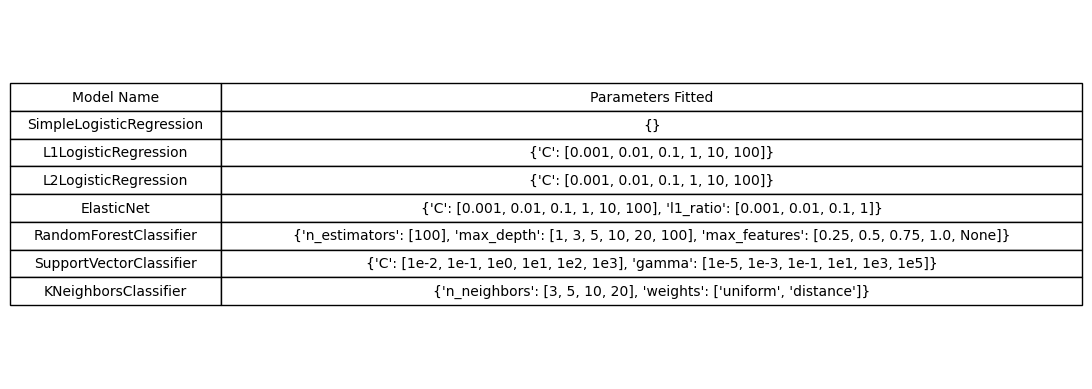

In [16]:
# Summarize the models and parameters
models_summary = [
    {"Model Name": "SimpleLogisticRegression", "Parameters Fitted": "{}"},
    {"Model Name": "L1LogisticRegression", "Parameters Fitted": "{'C': [0.001, 0.01, 0.1, 1, 10, 100]}"},
    {"Model Name": "L2LogisticRegression", "Parameters Fitted": "{'C': [0.001, 0.01, 0.1, 1, 10, 100]}"},
    {"Model Name": "ElasticNet", "Parameters Fitted": "{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.001, 0.01, 0.1, 1]}"},
    {"Model Name": "RandomForestClassifier", "Parameters Fitted": "{'n_estimators': [100], 'max_depth': [1, 3, 5, 10, 20, 100], 'max_features': [0.25, 0.5, 0.75, 1.0, None]}"},
    {"Model Name": "SupportVectorClassifier", "Parameters Fitted": "{'C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 'gamma': [1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5]}"},
    {"Model Name": "KNeighborsClassifier", "Parameters Fitted": "{'n_neighbors': [3, 5, 10, 20], 'weights': ['uniform', 'distance']}"}
]

# Convert to DataFrame
models_df = pd.DataFrame(models_summary)

# Plot the table
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=models_df.values, colLabels=models_df.columns, loc='center', cellLoc='center')

# Adjust row height
for key, cell in table.get_celld().items():
    cell.set_height(0.075)  # Adjust this value to make rows bigger

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(models_df.columns))))

# plt.title("Summary of Models and Parameters Fitted", fontsize=14)
plt.savefig("../figures/models/model_params.png", format="png", dpi=300)
plt.show()

In [17]:
# Find baseline f1 macro score
classes = np.unique(y)  # Identify unique classes
baseline_f1_macro = 0
best_class = None

# Iterate over all classes
for cls in classes:
    # Predict all points as the current class
    predictions = np.full_like(y, fill_value=cls)
    
    # Compute F1 Macro Score
    f1_macro = f1_score(y, predictions, average='macro')
    print(f"Class {cls}: F1 Macro Score = {f1_macro}")
    
    # Update best score and class
    if f1_macro > baseline_f1_macro:
        baseline_f1_macro = f1_macro
        best_class = cls

print(f"\nBest F1 Macro Score = {baseline_f1_macro} (achieved by classifying all points as class {best_class})")

Class Converted: F1 Macro Score = 0.060162601626016256
Class Demented: F1 Macro Score = 0.18754014129736674
Class Nondemented: F1 Macro Score = 0.2249851983422143

Best F1 Macro Score = 0.2249851983422143 (achieved by classifying all points as class Nondemented)


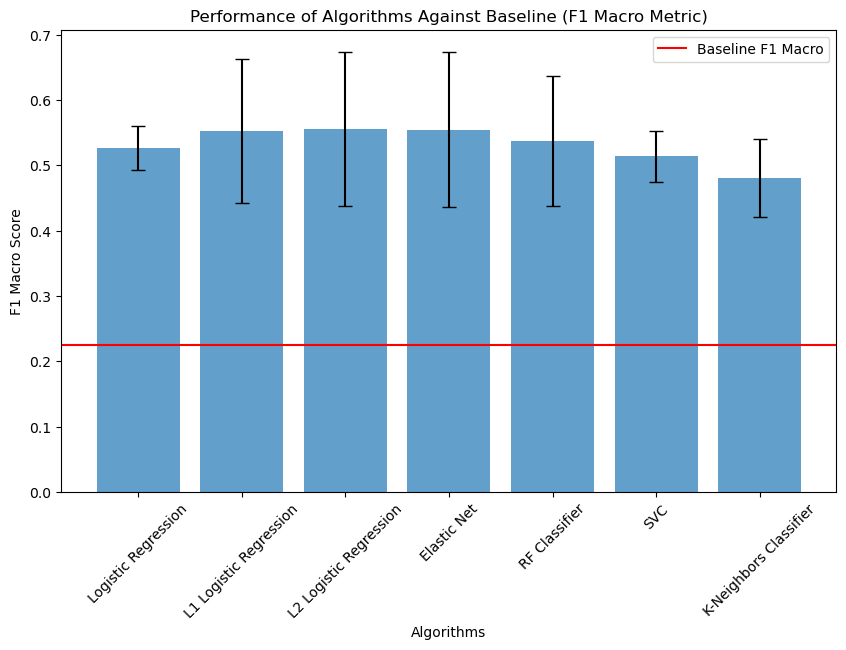

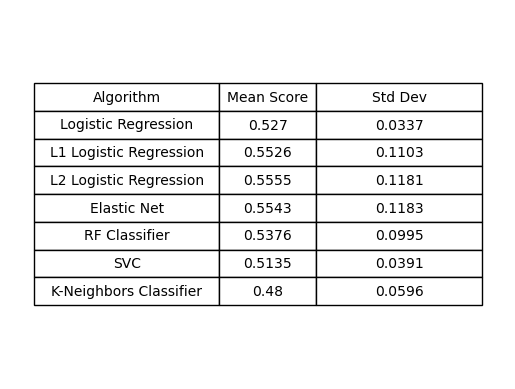

In [18]:
# Use f1 macro evaluation metric to plot all means and stddev of model scores
# SimpleLogisticRegression: Mean f1 = 0.7103, Std Dev = 0.0536
# L1LogisticRegression: Mean f1 = 0.7024, Std Dev = 0.0471
# L2LogisticRegression: Mean f1 = 0.7013, Std Dev = 0.0445
# ElasticNet: Mean f1 = 0.7046, Std Dev = 0.0472
# RandomForestClassifier: Mean f1 = 0.7013, Std Dev = 0.0550
# SupportVectorClassifier: Mean f1 = 0.7343, Std Dev = 0.1021
# KNeighborsClassifier: Mean f1 = 0.6224, Std Dev = 0.0513

mean_scores = []
stddev_scores = []
for model_name, (mean_score, stddev_score) in summary_f1_macro.items():
    mean_scores.append(mean_score)
    stddev_scores.append(stddev_score)
algorithms = ['Logistic Regression', 'L1 Logistic Regression', 'L2 Logistic Regression', 'Elastic Net',
              'RF Classifier', 'SVC', 'K-Neighbors Classifier']

# Plot means with standard deviations
plt.figure(figsize=(10, 6))
plt.bar(algorithms, mean_scores, yerr=stddev_scores, capsize=5, alpha=0.7)
plt.axhline(y=baseline_f1_macro, color='r', linestyle='-', label='Baseline F1 Macro')
plt.xlabel('Algorithms')
plt.ylabel('F1 Macro Score')
plt.title('Performance of Algorithms Against Baseline (F1 Macro Metric)')
plt.legend()
plt.xticks(rotation=45)
plt.savefig("../figures/models/results_against_baseline.png", format="png", dpi=300)
plt.show()

# Plot table summary
mean_scores = [round(score, 4) for score in mean_scores]
stddev_scores = [round(std, 4) if std != 0 else None for std in stddev_scores]

data = {
    'Algorithm': algorithms,
    'Mean Score': mean_scores,
    'Std Dev': stddev_scores
}
table_df = pd.DataFrame(data)

# Plot the table
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=table_df.values, colLabels=table_df.columns, loc='center', cellLoc='center')

# Adjust row height
for key, cell in table.get_celld().items():
    cell.set_height(0.075)  # Adjust this value to make rows bigger

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(models_df.columns))))

plt.savefig("../figures/models/model_results_table.png", format="png", dpi=300)
plt.show()


## Interpretability Analysis on SVC

In [19]:
file = open('../results/SupportVectorClassifier_f1_macro_results.save', 'rb')
best_models, test_scores = pickle.load(file)
file.close()

# Extract best overall SVC model 
# best_model_index = np.argmax(test_scores)  # Index of the highest score
# best_model_overall = best_models[best_model_index]
# print(f"Best Model Index: {best_model_index}, Best Model Random State: {best_model_index*29}, Test Score: {test_scores[best_model_index]}")

# Find indices of the top two best models
top_two_indices = np.argsort(test_scores)[-2:]  # Indices of the two highest scores
top_two_indices = top_two_indices[::-1]  # Sort in descending order

# Extract the top two models
best_model_1 = best_models[top_two_indices[0]]
best_model_2 = best_models[top_two_indices[1]]

print(f"Top 1 Best Model Index: {top_two_indices[0]}, Random State: {top_two_indices[0]*29}, Test Score: {test_scores[top_two_indices[0]]:.4f}")
print(f"Top 2 Best Model Index: {top_two_indices[1]}, Random State: {top_two_indices[1]*29}, Test Score: {test_scores[top_two_indices[1]]:.4f}")


Top 1 Best Model Index: 2, Random State: 58, Test Score: 0.5823
Top 2 Best Model Index: 3, Random State: 87, Test Score: 0.5722


In [20]:
# Extract the other-test split for the best model based on random state
outer_split = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=top_two_indices[1]*29)
for other_idx, test_idx in outer_split.split(X, y, groups=subject_ids):
            break # Break after the first split to separate out the test set for this state
X_other = X.iloc[other_idx]
y_other = y.iloc[other_idx]
subject_ids_other = subject_ids.iloc[other_idx] 
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

# Check test score to confirm split
y_pred = best_model_2.predict(X_test)
best_f1_overall_2 = f1_score(y_test, y_pred, average="macro")
print(best_f1_overall_2)

# ---CONFIRMED---

0.5722078667815101


['Converted' 'Demented' 'Nondemented']


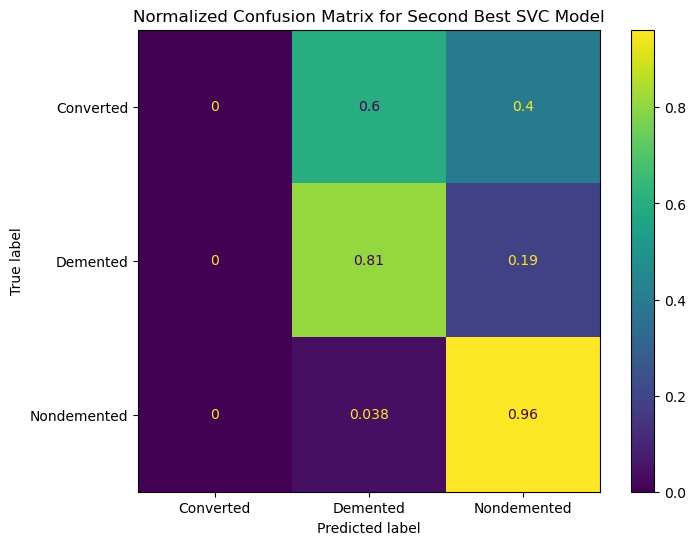

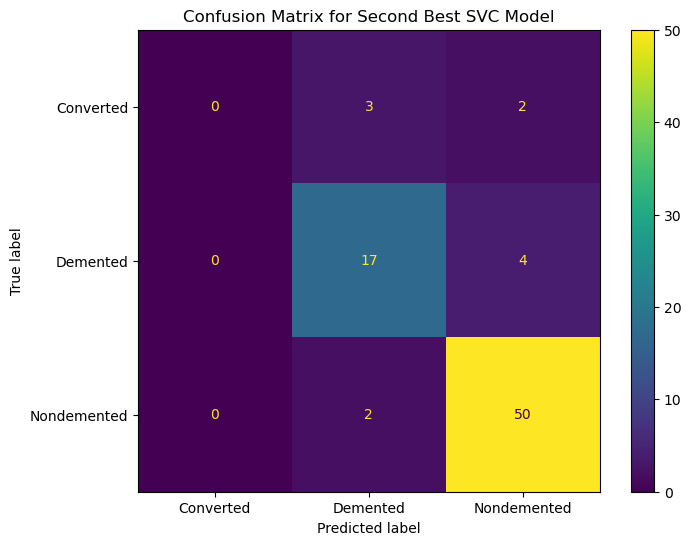

In [21]:
# Construct confusion matrix
print(np.unique(y_test))
fig, ax = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Converted', 'Demented', 'Nondemented'])
disp.plot(ax=ax)
ax.set_title("Normalized Confusion Matrix for Second Best SVC Model")
plt.savefig("../figures/models/norm_svc_cm.png", format="png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Converted', 'Demented', 'Nondemented'])
disp.plot(ax=ax)
ax.set_title("Confusion Matrix for Second Best SVC Model")
plt.savefig("../figures/models/svc_cm.png", format="png", dpi=300)
plt.show()

Index(['nWBV', 'SES', 'ASF', 'M/F', 'MMSE'], dtype='object')


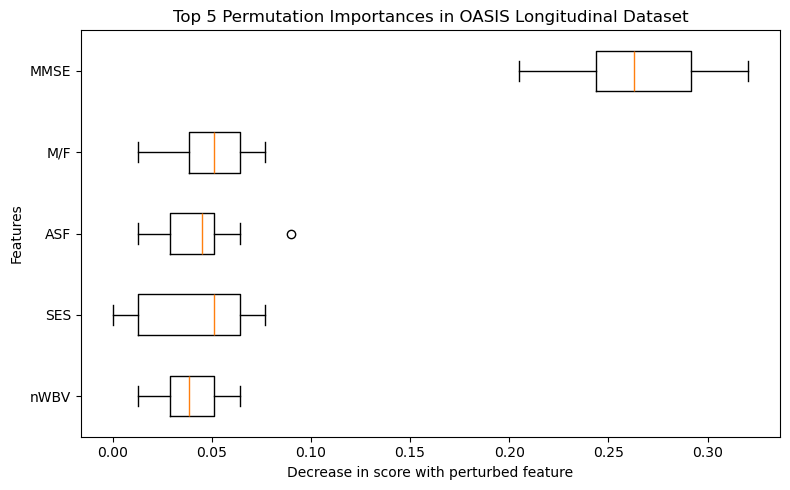

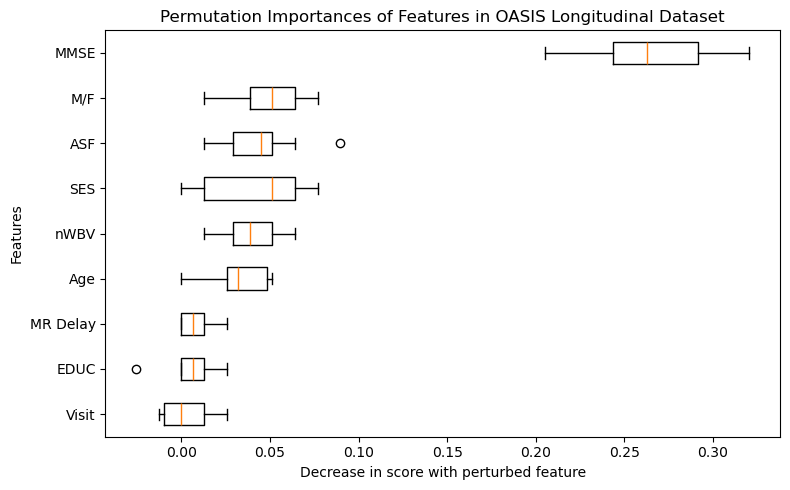

In [22]:
# Feature importance
# svc_model = best_model_2.named_steps['svc']
result = permutation_importance(best_model_2, X_test, y_test, n_repeats=10, random_state=29)
# print(len(X_test.columns))
sorted_idx = result.importances_mean.argsort()[::-1]
# print(np.argmax(result.importances_mean))
# print(sorted_idx)
ftr_names = X_test.columns

# top 5
top_5_idx = sorted_idx[:5][::-1]
top_5_importances = result.importances_mean[top_5_idx]
top_5_ftrs = ftr_names[top_5_idx]
print(top_5_ftrs)

plt.figure(figsize=(8,5))
plt.boxplot(
    result.importances[top_5_idx].T,
    vert=False,
    tick_labels=np.array(ftr_names)[top_5_idx]
)
# plt.axvline(test_score, color='red', linestyle='--', label='Test score')
plt.title("Top 5 Permutation Importances in OASIS Longitudinal Dataset")
plt.xlabel("Decrease in score with perturbed feature")
plt.ylabel("Features")
plt.tight_layout()
# plt.xlim(0)
plt.savefig("../figures/models/svc_perm_imp.png", format="png", dpi=300)
plt.show()

# all
sorted_idx = sorted_idx[::-1]
plt.figure(figsize=(8,5))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    tick_labels=np.array(ftr_names)[sorted_idx]
)
# plt.axvline(test_score, color='red', linestyle='--', label='Test score')
plt.title("Permutation Importances of Features in OASIS Longitudinal Dataset")
plt.xlabel("Decrease in score with perturbed feature")
plt.ylabel("Features")
plt.tight_layout()
# plt.xlim(0)
plt.savefig("../figures/models/svc_perm_imp_all.png", format="png", dpi=300)
plt.show()

In [23]:
# SHAP analysis
# random state = 116
shap.initjs()

# separate train data
inner_split = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=top_two_indices[1]*29) # n_splits=4 to set 3:1 ratio for train:val

# Generate four inner splits to split training and validation sets
for fold_number, (train_idx_rel, val_idx_rel) in enumerate(inner_split.split(X_other, y_other, groups=subject_ids_other )):
    train_idx = other_idx[train_idx_rel]
    val_idx = other_idx[val_idx_rel]
    break # get first fold

X_train = X.iloc[train_idx]
pipeline = best_model_2
svc_model = pipeline.named_steps['svc']

# Preprocess background data using the pipeline
X_train_transformed = pipeline[:-1].transform(X_train)  # Apply preprocessing from pipeline
X_test_transformed = pipeline[:-1].transform(X_test)

explainer = shap.KernelExplainer(svc_model.predict_proba, X_train_transformed)

# calculate shap values
shap_values = explainer.shap_values(X_test_transformed)
print(np.shape(shap_values))

Using 214 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/78 [00:00<?, ?it/s]

(78, 9, 3)


Class Index Mapping: ['Converted' 'Demented' 'Nondemented']


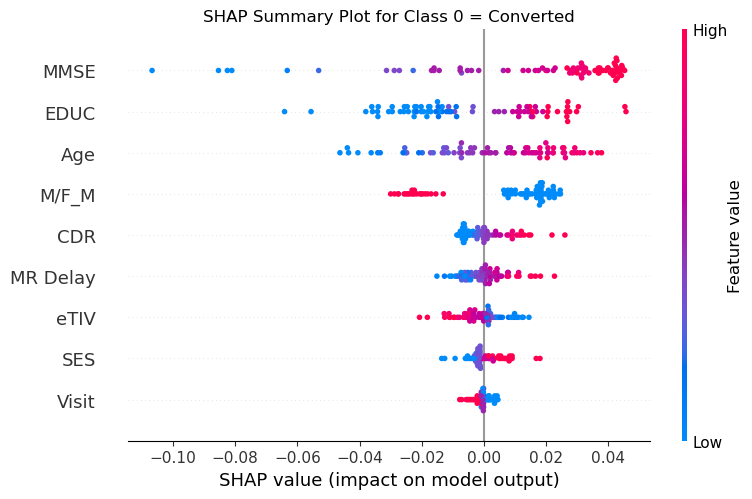

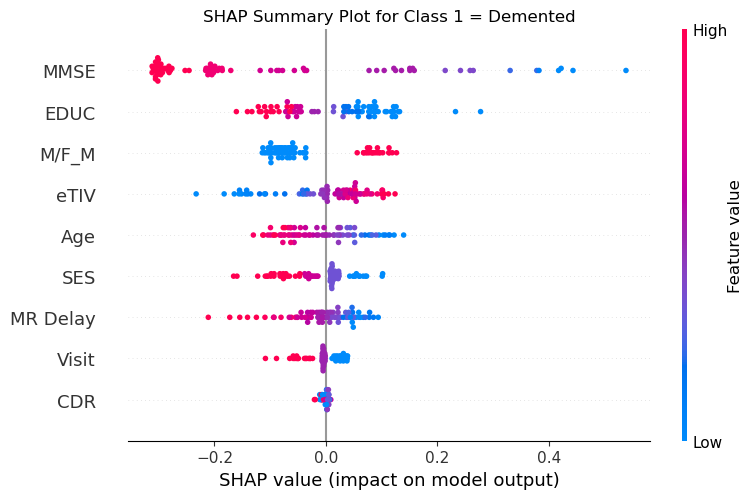

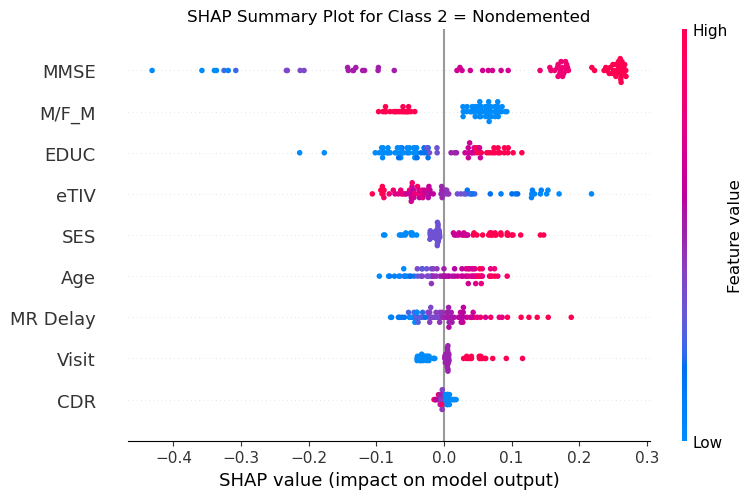

In [24]:
# print(shap_values.shape)
feature_names = ['Age', 'MMSE', 'EDUC', 'M/F_M', 'Visit', 'SES', 'CDR', 'MR Delay', 'eTIV', 'nWBV', 'ASF']


# plot global shap
class_mapping = pipeline[-1].classes_  # Assuming the classifier is the last step in the pipeline
print(f"Class Index Mapping: {class_mapping}")

plt.title("SHAP Summary Plot for Class 0 = Converted")
shap.summary_plot(shap_values[:,:,0], X_test_transformed,feature_names = feature_names)
plt.show()

plt.title("SHAP Summary Plot for Class 1 = Demented")
shap.summary_plot(shap_values[:,:,1], X_test_transformed,feature_names = feature_names)
plt.show()

plt.title("SHAP Summary Plot for Class 2 = Nondemented")
shap.summary_plot(shap_values[:,:,2], X_test_transformed,feature_names = feature_names)
plt.show()

In [25]:
# individual point SHAPs

# identify one index for each class
print(y_test.shape)
class_0_index = np.where(y_test == 'Converted')[0][0]  # find the first sample in the test set that is converted
print(class_0_index)
class_1_index = np.where(y_test == 'Demented')[0][0]
print(class_1_index)
class_2_index = np.where(y_test == 'Nondemented')[0][0]
print(class_2_index)

# list of indices and corresponding class labels
indices = [class_0_index, class_1_index, class_2_index]
classes = [0, 1, 2]

# # round shap values for cleaner force plots // doesn't work
# shap_values_rounded = np.round(shap_values, 4)

# loop through each class to plot the SHAP force plot
for class_idx, sample_idx in zip(classes, indices):
    print(f"Class {class_idx} - Explaining sample index {sample_idx}")

    shap.force_plot(
        explainer.expected_value[class_idx],
        shap_values[sample_idx, :, class_idx],
        features=X_test_transformed[sample_idx, :],
        feature_names=feature_names,
        # show=False,
        matplotlib=True,
        figsize=(60,5)
    )#.savefig(f"force_plot_class_{class_idx}.png", dpi=300) # uncomment this part and show=False to save figure

(78,)
18
8
0
Class 0 - Explaining sample index 18


IndexError: index 9 is out of bounds for axis 0 with size 9

## Interpretability Analysis on LogReg

In [ ]:
file = open('../results/SimpleLogisticRegression_f1_macro_results.save', 'rb')
best_models, test_scores = pickle.load(file)
file.close()

# Extract best overall SVC model 
best_model_index_lr = np.argmax(test_scores)  # Index of the highest score
print(test_scores)
best_model_overall = best_models[best_model_index_lr]
print(f"Best Model Index: {best_model_index_lr}, Best Model Random State: {best_model_index_lr*29}, Test Score: {test_scores[best_model_index_lr]}")

[0.6264264264264264, 0.7556418973611786, 0.6479260369815093, 0.7500476462740613, 0.7521741939652387, 0.6381551362683439, 0.7507936507936508, 0.6743055555555556, 0.7379679144385026, 0.7697175141242938]
Best Model Index: 9, Best Model Random State: 261, Test Score: 0.7697175141242938


Best Model Index: 9, Best Model Random State: 261, Test Score: 0.7697175141242938
Coefficients: [-0.64082635 -1.10232532 -0.61337046  0.58592696 -0.52317734 -0.18759374
  2.68160466 -0.16402534 -0.20674089 -0.57349537  0.11806289]


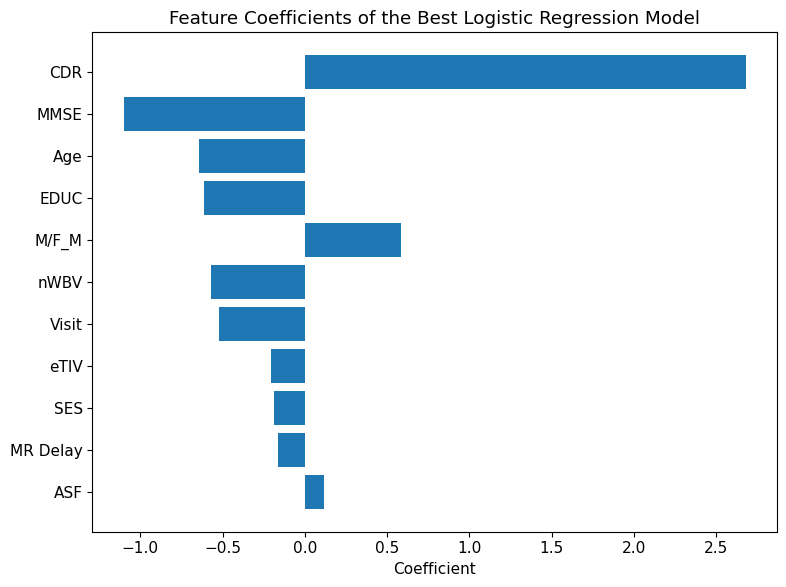

In [ ]:
# Load best models and test scores
file = open('../results/SimpleLogisticRegression_f1_macro_results.save', 'rb')
best_models, test_scores = pickle.load(file)
file.close()

# Extract best overall logistic regression model
best_model_index_lr = np.argmax(test_scores)
best_model_overall = best_models[best_model_index_lr]
# print(best_model_overall)
print(f"Best Model Index: {best_model_index_lr}, Best Model Random State: {best_model_index_lr*29}, Test Score: {test_scores[best_model_index_lr]}")

# Extract logistic regression model and its coefficients
logistic_model = best_model_overall.named_steps['logisticregression']
coefs = logistic_model.coef_[1] # Assuming binary classification
print("Coefficients:", coefs)

# Feature names
# feature_names = ['Age', 'MMSE', 'EDUC', 'M/F_M', 'Visit', 'SES', 'CDR', 'MR Delay', 'eTIV', 'nWBV', 'ASF']

# Sort coefficients by absolute values
sorted_indices = np.argsort(np.abs(coefs))

# Plot all coefficients
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 11})

plt.barh(np.arange(len(coefs)), coefs[sorted_indices])
plt.yticks(np.arange(len(coefs)), np.array(feature_names)[sorted_indices])
plt.xlabel('Coefficient')
plt.title('Feature Coefficients of the Best Logistic Regression Model')
plt.tight_layout()

plt.savefig('../figures/models/LR_coefs_scaled_all.png', dpi=300)

plt.show()